# Experiment 01 - Sparsity Profile for ResNet-50

## Activation Function Impact on CNN Edge Inference
### Martin Power
### 9939245

A pre-trained ResNet-50 model is used with the ImageNet dataset. As the model is pre-trained, only the 50,000-image validation set is required. The pre-trained model is instrumented to allow the layer-to-layer activations to be observed. The presence of zeroes in these inter layer activations is measured to determine the per layer sparsity profile.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from matplotlib import pyplot as plt
import cv2

import tensorflow_datasets as tfds

### Import ImageNet2012 Validation Set

In [2]:
ds, ds_info = tfds.load('imagenet2012', split='validation', with_info=True)

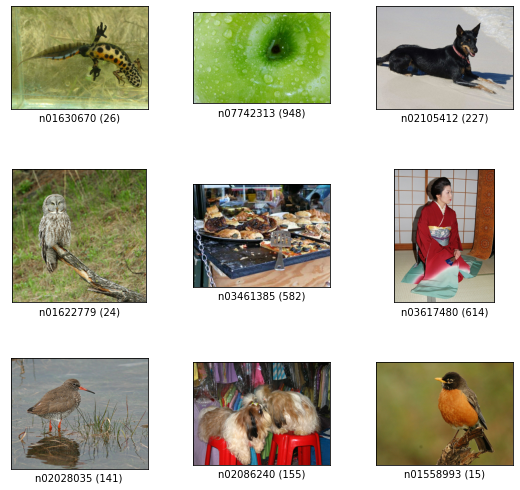

In [3]:
fig = tfds.show_examples(ds, ds_info)

## ResNet-50 Model

* Import from Keras
* Make example Prediction
* Print Summary and plot model
* Add functions to preprocess image, display image and decode predictions

In [4]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

model = ResNet50(weights='imagenet')

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

Predicted: [('n01871265', 'tusker', 0.41223323), ('n02504458', 'African_elephant', 0.39349228), ('n02504013', 'Indian_elephant', 0.07712169)]


In [5]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

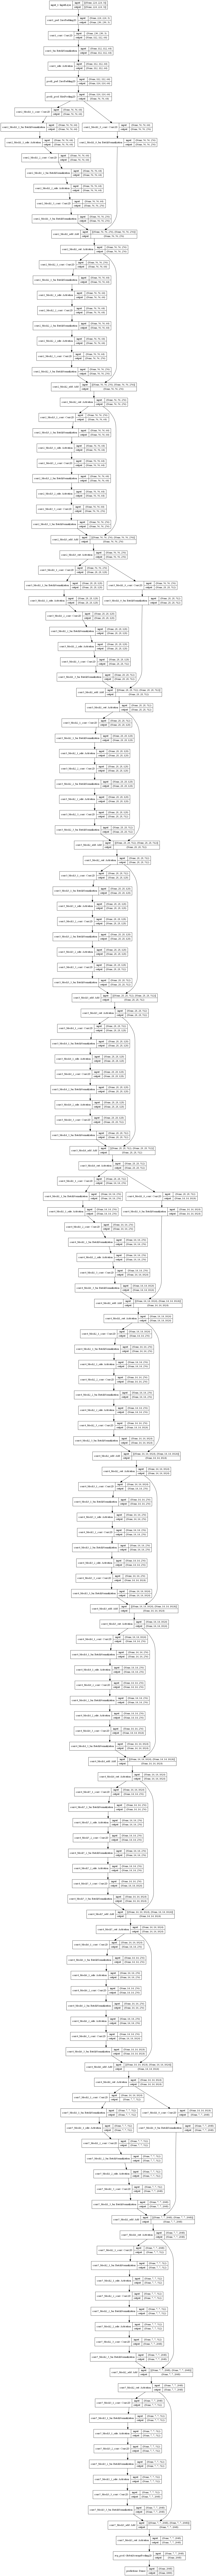

In [6]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [7]:
def show_image(img):
    plt.imshow(np.asarray(img).astype('uint8'))
    plt.show()
    

In [8]:
def make_prediction(img):
    x = image.img_to_array(img)
    x_copy = x.copy()
    x_copy = np.expand_dims(x_copy, axis=0)
    x_copy = preprocess_input(x_copy)
    
    preds = model.predict(x_copy)
    
    return preds

In [9]:
def preprocess_img(img):
    img = tf.image.resize_with_pad(np.asarray(img), 224, 224)
    x = image.img_to_array(img)
    x_copy = x.copy()
    #show_image(x_copy)
    x_copy = np.expand_dims(x_copy, axis=0)
    x_copy = preprocess_input(x_copy)
       
    return x_copy

### Get Output Activations from Each Layer of Model

The code in the next two cells is based on cdoe provided at https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer/45430345 "Keras, How to get the output of each layer?" and has been updated to work with the latest versions of Keras and Tensorflow

In [10]:
#Getting output of each layer
from tensorflow.keras import backend as K

input_shape = (224, 224, 3)
inp = model.input                                           # input 
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

In [11]:
def get_layer_outs(img):
    layer_outs=[]
    test = preprocess_img(img)
    count = 0
    for func in functors:
        layer_outs.append(np.asarray(func([test])))
        count+=1
    
    return layer_outs

### Pandas Data Frame to Store Sparsity Profile Info

The Pandas Data Frame will store the following information for each layer
* Image Number
* Image Name
* Layer Number
* Layer Name
* Layer Activation Type (ReLU/SoftMax)
* The number of non-zero activations
* The total number of activations (Dense)
* The observed activation sparsity ((Total-NonZero)/(Total))
* The minimum, maximum and mean activation values plus the standard deviation of these values
* The label associated with the image being processed and the prediction from the model

The update_sparsity_df() function gathers all this information and returns a dataframe per image. These per-image dataframes are consolidated as a single dataframe for the entire run

In [12]:
column_names = ["img_num", "img_name", "layer_num", "layer_name", "layer_act", "non_zero_act", "total_act", "sparsity", "min", "max", "mean", "std", "label", "prediction"]

num_columns = len(column_names)

In [13]:
def update_sparsity_df(img, label, prediction, debug=False):
    layer_sparsity = np.zeros(np.count_nonzero(relu_layers))
    layer_sparsity_idx = 0
    layer_outs = get_layer_outs(img)
    if(debug):
        print(layer_outs)
    dff = pd.DataFrame(columns=column_names)
    for i in range(len(layer_outs)):
        if(relu_layers[i]==1):
            non_zero = np.count_nonzero(layer_outs[i])
            total    = layer_outs[i].size
            zero     = total-non_zero
            sparsity = (100.0*zero)/total
            density  = (100.0*non_zero)/total
            min_val  = layer_outs[i].min()
            max_val  = layer_outs[i].max()
            mean_val = layer_outs[i].mean()
            std_val  = layer_outs[i].std()
            if(debug):
                print(layer_names[i],"\tNon_Zero",non_zero,"\tTotal",total,"\t%Sparsity",sparsity,"\t%Density",density)
            layer_sparsity[layer_sparsity_idx]= sparsity
            layer_sparsity_idx+=1
            # Create temporaty dataframe
            tmp_df_data = np.array([img_num, img_name, i, layer_names[i], layer_acts[i], non_zero, total, sparsity, min_val, max_val, mean_val, std_val, label, prediction])
            df_tmp = pd.DataFrame(tmp_df_data.reshape(1,num_columns), columns=column_names)
            dff = dff.append(df_tmp, ignore_index = True)
    
    return dff

### Identify Convolution Layers within Model

This code parses the model and finds all the layers that have a ReLU (or SoftMax) activation function.

An array called "relu_layers" is used to store this information. Every layer with a non-linear activation is set to 1 in this array. This array is then used in later code to determine which layers are analysed for sparsity profile or not

In [14]:
n=0
relu=0

relu_layers = np.zeros((len(model.layers)))
layer_names = []
layer_acts = []
for layer in model.layers:
    #print(layer.__class__.__name__)
    try:
        if(layer.activation.__name__!="linear"):
            print(n,"\t",layer.name,"\t", layer.__class__.__name__,"\t", layer.activation.__name__)
            relu+=1
            relu_layers[n]=1
            
    except AttributeError:
        print(n,"\t",layer.name,"\t", layer.__class__.__name__)
        
    layer_names.append(layer.name)
    if(relu_layers[n]==1):
        layer_acts.append(layer.activation.__name__)
    else:
        layer_acts.append("None")
    n+=1
        
print("Number of layers with ReLU:",relu)
print("Number of layers:",n)

0 	 input_1 	 InputLayer
1 	 conv1_pad 	 ZeroPadding2D
3 	 conv1_bn 	 BatchNormalization
4 	 conv1_relu 	 Activation 	 relu
5 	 pool1_pad 	 ZeroPadding2D
6 	 pool1_pool 	 MaxPooling2D
8 	 conv2_block1_1_bn 	 BatchNormalization
9 	 conv2_block1_1_relu 	 Activation 	 relu
11 	 conv2_block1_2_bn 	 BatchNormalization
12 	 conv2_block1_2_relu 	 Activation 	 relu
15 	 conv2_block1_0_bn 	 BatchNormalization
16 	 conv2_block1_3_bn 	 BatchNormalization
17 	 conv2_block1_add 	 Add
18 	 conv2_block1_out 	 Activation 	 relu
20 	 conv2_block2_1_bn 	 BatchNormalization
21 	 conv2_block2_1_relu 	 Activation 	 relu
23 	 conv2_block2_2_bn 	 BatchNormalization
24 	 conv2_block2_2_relu 	 Activation 	 relu
26 	 conv2_block2_3_bn 	 BatchNormalization
27 	 conv2_block2_add 	 Add
28 	 conv2_block2_out 	 Activation 	 relu
30 	 conv2_block3_1_bn 	 BatchNormalization
31 	 conv2_block3_1_relu 	 Activation 	 relu
33 	 conv2_block3_2_bn 	 BatchNormalization
34 	 conv2_block3_2_relu 	 Activation 	 relu
36 	 conv2_b

### Process Images from Validation Set and Extract Activation Sparsity Profile

* This code takes 1000 images from the validation and  process each image one-by-one.
* For each image, update_sparsity_df() is used to extract the activation sparsity information
* The image is consolidated in a Pandas dataframe


In [2]:
ds_short = ds.take(1000)  # Only take a single example


count =  0
correct = 0
top5_correct = 0

display_images = False
debug_code = False

df1 = pd.DataFrame(columns=column_names)

for example in ds_short:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    file_name = example["file_name"]
    ds_image = example["image"]
    ds_label = example["label"]
    
    img_num = count
    img_name = file_name.numpy()[:-5]
    
    if(debug_code):
        print(ds_image.shape, file_name, ds_label)
    if(display_images):
        show_image(ds_image)
    #tf.print(ds_label)
    #tf.print(file_name)

    input_image = tf.image.resize_with_pad(np.asarray(ds_image), 224, 224)
    if(display_images):
        show_image(input_image)

    preds = make_prediction(input_image)
    if(debug_code):
        print('Predicted:', decode_predictions(preds, top=3)[0])
    
    count+=1
    # Top-1 Accuracy
    if(ds_label == np.argmax(preds)):
        correct+=1
    # Top-5 Accuracy
    idx = (-preds.reshape(-1)).argsort()[:5]
    if ds_label in idx:
        top5_correct+=1
        
    df_tmp = update_sparsity_df(input_image,ds_label.numpy(),np.argmax(preds))
    df1 = df1.append(df_tmp, ignore_index = True)
    
        
accuracy = float(correct)/float(count)
top5_accuracy = float(top5_correct)/float(count)
print("Total Images:",count)
print("Top-1 Correct:",correct)
print("Top-5 Correct:",top5_correct)
print("Top-1 Accuracy:",accuracy)
print("Top-5 Accuracy:",top5_accuracy)


NameError: name 'ds' is not defined

### Print the Activation Sparsity Profile Dataframe

In [18]:
df1

img_num                 img_name layer_num           layer_name  \
0           0  ILSVRC2012_val_00009670         4           conv1_relu   
1           0  ILSVRC2012_val_00009670         9  conv2_block1_1_relu   
2           0  ILSVRC2012_val_00009670        12  conv2_block1_2_relu   
3           0  ILSVRC2012_val_00009670        18     conv2_block1_out   
4           0  ILSVRC2012_val_00009670        21  conv2_block2_1_relu   
...       ...                      ...       ...                  ...   
49995     999  ILSVRC2012_val_00049979       164     conv5_block2_out   
49996     999  ILSVRC2012_val_00049979       167  conv5_block3_1_relu   
49997     999  ILSVRC2012_val_00049979       170  conv5_block3_2_relu   
49998     999  ILSVRC2012_val_00049979       174     conv5_block3_out   
49999     999  ILSVRC2012_val_00049979       176          predictions   

      layer_act non_zero_act total_act            sparsity            min  \
0          relu       573286    802816  28.590611049107142            0.0   
1          relu       118341    200704   41.03704958545919            0.0   
2          relu       123320    200704  38.556281887755105            0.0   
3          relu       471679    802816   41.24693578603316            0.0   
4          relu        99077    200704   50.63526387117347            0.0   
...         ...          ...       ...                 ...            ...   
49995      relu        22815    100352   77.26502710459184            0.0   
49996      relu         3377     25088   86.53938137755102            0.0   
49997      relu         6883     25088   72.56457270408163            0.0   
49998      relu        19600    100352            80.46875            0.0   
49999   softmax         1000      1000                 0.0  1.1606465e-19   

              max        mean          std label prediction  
0       15.241227   1.4968073    1.6995037    26         26  
1       7.6446257   0.6017996    0.9300778    26         26  
2       10.136611  0.86618936    1.2073094    26         26  
3      11.7580385   0.6736166    0.9162828    26         26  
4        7.671635   0.4621648    0.6724222    26         26  
...           ...         ...          ...   ...        ...  
49995    30.65545  0.50999004    1.5618956   455        455  
49996    4.393456   0.0677654   0.26967126   455        455  
49997    7.506394   0.1595537   0.44034153   455        455  
49998   53.117393    0.604951    2.1104357   455        455  
49999         1.0       0.001  0.031606965   455        455  

[50000 rows x 14 columns]

### Export and Store DataFrame
* Create a unique timestamp to identify each stored dataframe
* Write out the dataframe as a CSV
* Pickle the dataframe also

In [19]:
from datetime import date
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()

dt_string = now.strftime("%Y%m%d_%H%M%S")
print("date and time =", dt_string)	
	

date and time = 20210811_013305


In [20]:
csv_string = "imagenet_sparsity_"+dt_string+".csv"
pkl_string = "imagenet_sparsity_"+dt_string+".pkl"

In [22]:
df1.to_csv(csv_string)

In [23]:
df1.to_pickle(pkl_string)